## Unmet targets workflow  

This notebook outlines the steps to identify possible reasons why the targets were not met to help guide the user to take an appropriate action in each case

### Identify unmet targets: 
REQUIREMENTS:  
    File **'output_mvbest.csv'**, columns 'Target Met' + 'MPM' (Minimum Proportion Met)

### Worflow for unmet solutions:
    If the feature is not met but by very little --> mark as met or decrease MISSLEVEL 
    Else:
        If the feature is in locked-out planning units --> Send warning/mark as met/rethink problem
        Else:
            If the feature is in a high cost area --> Increase SPF
            Else:
                The feature has low range and/or is isolated --> Increase SPF
                
PARAMETERS:  
* **threshold met**: when to consider a target as met (by default the misslevel set at input.dat)--> number between 0-1  
* **lock_out_limit**: max percentage of the feature pu's that are in locked out areas that trigger response --> number between 0-1 
* **high_cost_quantile**: value to define what is high cost (quatile is used to generalize any cost values) --> number between 0-1 
* **hcost_limit**: max percentage of the feature pu's that are in high cost areas that trigger response --> number between 0-1 


In [1]:
%run marxan_utils.ipynb 

### Helper functions

In [2]:
def locatePU(MARXAN_FOLDER:str,MARXAN_INPUTDATA:str,pus_of_interest=None, feature=None) -> dict:
    """ Check if feature is in an area of interest
    """
    userInputFile = readInput(MARXAN_FOLDER,MARXAN_INPUTDATA)
    puvsp = validateFile(MARXAN_FOLDER,MARXAN_INPUTDATA, planningUnitVSConservationFeatureV)
    
    feature_in_pu=puvsp[(puvsp['species']==feature) & (puvsp.pu.isin(pus_of_interest))]
    
    if len(feature_in_pu)== 0: 
        percentage_in_pu = 0
    else:
        amount_total = puvsp[puvsp['species']==feature].groupby(['species']).sum('amount').reset_index().amount.values[0]
        amount_in_pu= feature_in_pu.groupby('species').sum('amount').reset_index().amount.values[0]
        percentage_in_pu = round((amount_in_pu/amount_total)*100,2)
    return percentage_in_pu

def unmetDecisionTree(MARXAN_FOLDER, MARXAN_INPUTDATA,
                      lock_out_limit=0.5, 
                      high_cost_quantile= 0.7, 
                      hcost_limit=0.2):
    
    """Follow the decision flow:
    - Check if the target is missed by little (already considering the defined misslevel)
    - Check if the feature is in a locked-out area 
    - Check if the feature is in a high cost area
    - Check if the feature is very isolated or the range of the feature is very small
    
    Parameteres:
    - threshold met: when to consider a target as met (dy default the misslevel set at input.dat)
    - lock_out_limit: amount of the feature pu's that are in locked out areas that trigger response
    - high_cost_quantile: decide what is high cost
    - hcost_limit: amount of the feature pu's that are in high cost areas that trigger response
    """
    
    # Validate and read files
    userInputFile = readInput(MARXAN_FOLDER,MARXAN_INPUTDATA)
    pu = validateFile(MARXAN_FOLDER,MARXAN_INPUTDATA, planningUnits)
    puvsp = validateFile(MARXAN_FOLDER,MARXAN_INPUTDATA, planningUnitVSConservationFeatureV)
    mvbest= validateFile(MARXAN_FOLDER,MARXAN_INPUTDATA, OutputMV)
    
    df = mvbest[['Conservation_Feature','Target_Met','MPM']].copy()
    threshold_met = userInputFile.MISSLEVEL
    
    if len(df.loc[df['Target_Met']=='no','Conservation_Feature'])==0:
        unmet = {'None':'All targets met'}
    else: 
        for feature in list(df.loc[df['Target_Met']=='no','Conservation_Feature'].values):
        
            # 1. Close to target 
            # Solution: 
            # - Mark as met: Modify output_mvbest.csv (Target Met) MPM: minimum proportion met
            # - Decrease MISSLEVEL (input.dat)
            if (df.loc[df['Conservation_Feature']==feature,'MPM']>=threshold_met-(threshold_met*1/100)).bool():
                df.loc[df['Conservation_Feature']==feature,'Eval']='Close to target (1% away of misslevel)'

            else:
        
            # 2. In lock-out areas (re-think problem)
            # Solution: 
            # - Rethink problem (Assume not met)
            # - Unblock lock-out pu: Modifir pu.dat (status)
        
                pu_excluded = list(pu[pu['status']==3].id) 
                excluded_per = locatePU(MARXAN_FOLDER,MARXAN_INPUTDATA,pus_of_interest=pu_excluded, feature=feature)/100
                if excluded_per > lock_out_limit: df.loc[df['Conservation_Feature']==feature,'Eval'] = f'{excluded_per*100} % in locked-out areas'
            
                else:
                        
            # 3. In high cost areas (increase SPF)
            # Solution: 
            # - Increase SPF: Modify spec.dat (spf)
        
                    pu_hcost = list(pu[pu['cost']>pu['cost'].quantile([high_cost_quantile], interpolation='nearest').values[0]].id)
                    hcost_per = locatePU(MARXAN_FOLDER,MARXAN_INPUTDATA,pus_of_interest=pu_excluded, feature=feature)/100
                    if hcost_per > hcost_limit: df.loc[df['Conservation_Feature']==feature,'Eval'] = f'{hcost_per*100} % in high cost areas'
                
                    else:
        
            # 4. Small range or isolated 
            # Solution:
            # - Increase SPF: Modify spec.dat (spf)
                        feat_range = round(puvsp[puvsp['species']==feature].count().pu/len(pu)*100,2)
                        df.loc[df['Conservation_Feature']==feature,'Eval'] = f'Small range ({feat_range} % of planning area) or isolated'     
        
            unmet = dict(zip(df[df['Target_Met']=='no'].Conservation_Feature, df[df['Target_Met']=='no'].Eval))
    return unmet

In [7]:
### Next step is to modify input the files according to this output, and then run marxan again

## Example data

In [6]:
#MARXAN_FOLDER = '/home/jovyan/work/datasets/raw/Marxan_Targets/example_1_Papua'
MARXAN_FOLDER = '/home/jovyan/work/datasets/raw/demo_Papua_New_Guinea/marxan_Papua_New_Guinea'

MARXAN_INPUTDATA = 'input.dat'

In [7]:
df = gapAnalysis(MARXAN_FOLDER, 'input.dat')

In [8]:
df.head()

,id,target,prop,name,amount_total,amount_target,amount_lock,prop_lock,target_met_pre,Target,Amount_Held,Occurrence_Target,Occurrences_Held,Separation_Target,Separation_Achieved,Target_Met,MPM,prop_best,prop_best_minus_lock
0,1,83.2,0.2,0,416.0,83.2,0.0,0.000000,no,83.2,84.0,0.0,84.0,0.0,0.0,yes,1.0,0.201923,0.201923
1,2,27.4,0.2,0,137.0,27.4,0.0,0.000000,no,27.4,28.0,0.0,28.0,0.0,0.0,yes,1.0,0.204380,0.204380
2,3,32.8,0.2,0,164.0,32.8,0.0,0.000000,no,32.8,33.0,0.0,33.0,0.0,0.0,yes,1.0,0.201220,0.201220
3,4,5.6,0.2,0,28.0,5.6,14.0,0.500000,yes,5.6,6.0,0.0,6.0,0.0,0.0,yes,1.0,0.214286,-0.285714
4,5,10.6,0.2,0,53.0,10.6,3.0,0.056604,yes,10.6,11.0,0.0,11.0,0.0,0.0,yes,1.0,0.207547,0.150943


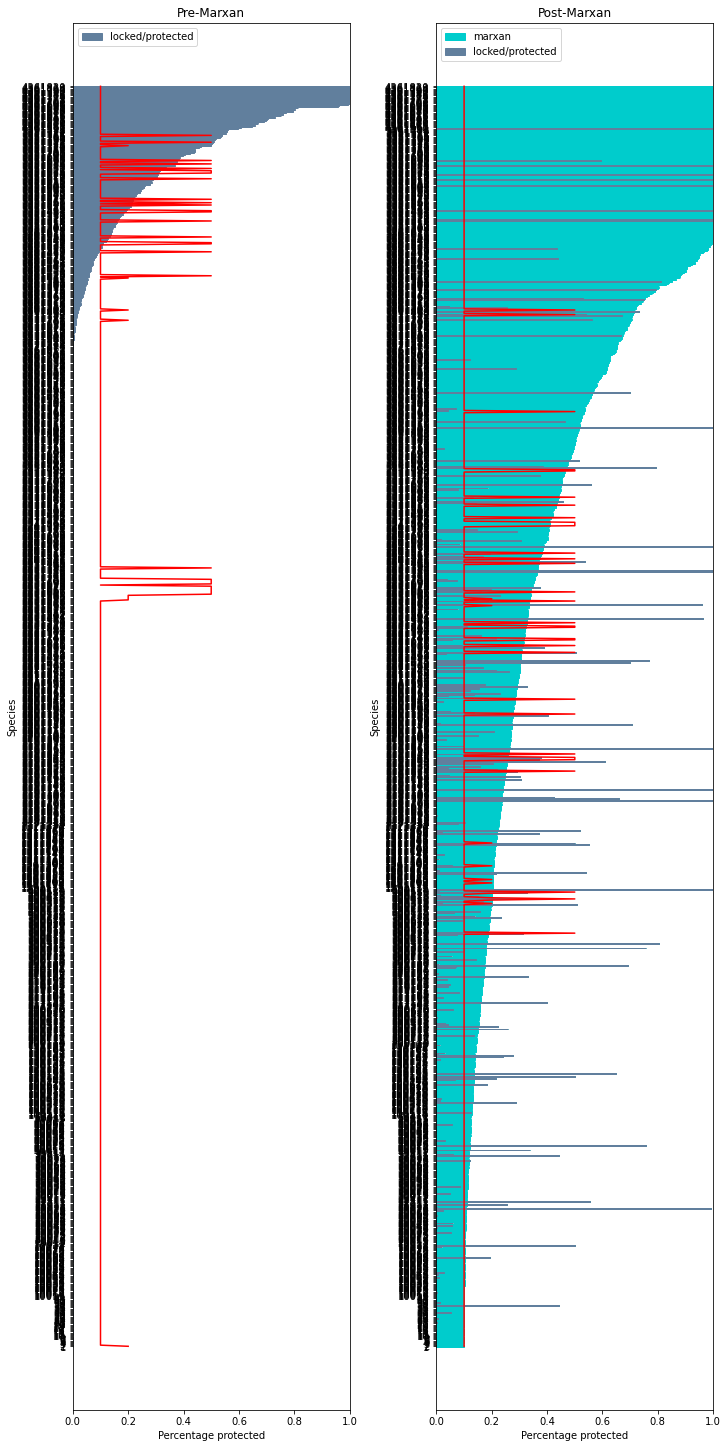

In [9]:
fig, anx = plt.subplots(nrows=1, ncols=2,figsize=(10,20), constrained_layout=True)
plotGap(df, 'Pre-Marxan', anx[0], post_marxan=False)
plotGap(df, 'Post-Marxan', anx[1], post_marxan=True)

In [4]:
unmet_dict = unmetDecisionTree(MARXAN_FOLDER, MARXAN_INPUTDATA,
                      lock_out_limit=0.5, 
                      high_cost_quantile= 0.7, 
                      hcost_limit=0.2)

In [5]:
unmet_dict

{4361690: 'Small range (0.06 % of planning area) or isolated',
 4361619: 'Small range (0.09 % of planning area) or isolated',
 3351729: 'Small range (0.05 % of planning area) or isolated',
 3351696: 'Close to target (1% away of misslevel)',
 3351690: 'Small range (0.01 % of planning area) or isolated',
 3351309: 'Small range (0.02 % of planning area) or isolated',
 3281565: 'Small range (0.0 % of planning area) or isolated',
 3281437: 'Small range (0.02 % of planning area) or isolated',
 3281316: 'Small range (0.01 % of planning area) or isolated',
 3271794: 'Small range (0.04 % of planning area) or isolated',
 3271775: 'Small range (0.03 % of planning area) or isolated',
 3271633: 'Small range (0.03 % of planning area) or isolated',
 3271611: 'Small range (0.0 % of planning area) or isolated',
 3271541: 'Small range (0.0 % of planning area) or isolated',
 3261701: 'Small range (0.0 % of planning area) or isolated',
 3261631: 'Small range (0.01 % of planning area) or isolated',
 326130